In [1]:
from tqdm import tqdm

import glob, os
import numpy as np
import torch

from IPython.display import clear_output

DEVICE = torch.device("cpu") #torch.device("mps")
BATCH_SIZE = 32
NUM_WINDOWS = 19

In [2]:
#from src.make_features import loaders
#from src.make_features import norm_adj

In [3]:
import torch
#from .temporalgcn import TGCN
#from .temporalgcn import TGCN2
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import TGCN


class A3TGCN(torch.nn.Module):
    r"""An implementation of the Attention Temporal Graph Convolutional Cell.
    For details see this paper: `"A3T-GCN: Attention Temporal Graph Convolutional
    Network for Traffic Forecasting." <https://arxiv.org/abs/2006.11583>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        periods (int): Number of time periods.
        improved (bool): Stronger self loops (default :obj:`False`).
        cached (bool): Caching the message weights (default :obj:`False`).
        add_self_loops (bool): Adding self-loops for smoothing (default :obj:`True`).
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        periods: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True
    ):
        super(A3TGCN, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.periods = periods
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops
        self._setup_layers()

    def _setup_layers(self):
        self._base_tgcn = TGCN(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self._attention = torch.nn.Parameter(torch.empty(self.periods, device=device))
        torch.nn.init.uniform_(self._attention)

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.

        Arg types:
            * **X** (PyTorch Float Tensor): Node features for T time periods.
            * **edge_index** (PyTorch Long Tensor): Graph edge indices.
            * **edge_weight** (PyTorch Long Tensor, optional)*: Edge weight vector.
            * **H** (PyTorch Float Tensor, optional): Hidden state matrix for all nodes.

        Return types:
            * **H** (PyTorch Float Tensor): Hidden state matrix for all nodes.
        """
        H_accum = 0
        probs = torch.nn.functional.softmax(self._attention, dim=0)
        for period in range(self.periods):
            Xt = X[:, period, :]
            edge_weight_t = edge_weight[:, period]
            H_accum = H_accum + probs[period] * self._base_tgcn(Xt, edge_index, edge_weight_t, H)
            
        return H_accum

In [4]:
import torch
from torch_geometric.nn import GCNConv


class TGCN(torch.nn.Module):
    r"""An implementation of the Temporal Graph Convolutional Gated Recurrent Cell.
    For details see this paper: `"T-GCN: A Temporal Graph ConvolutionalNetwork for
    Traffic Prediction." <https://arxiv.org/abs/1811.05320>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        improved (bool): Stronger self loops. Default is False.
        cached (bool): Caching the message weights. Default is False.
        add_self_loops (bool): Adding self-loops for smoothing. Default is True.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True,
    ):
        super(TGCN, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.add_self_loops = add_self_loops

        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_z = GCNConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )

        self.linear_z = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_reset_gate_parameters_and_layers(self):

        self.conv_r = GCNConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )

        self.linear_r = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_h = GCNConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            improved=self.improved,
            cached=self.cached,
            add_self_loops=self.add_self_loops,
        )

        self.linear_h = torch.nn.Linear(2 * self.out_channels, self.out_channels)

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, edge_weight, H):
        Z = torch.cat([self.conv_z(X, edge_index, edge_weight), H], axis=1)
        Z = self.linear_z(Z)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, edge_weight, H):
        R = torch.cat([self.conv_r(X, edge_index, edge_weight), H], axis=1)
        R = self.linear_r(R)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, edge_weight, H, R):
        H_tilde = torch.cat([self.conv_h(X, edge_index, edge_weight), H * R], axis=1)
        H_tilde = self.linear_h(H_tilde)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
    ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.

        Arg types:
            * **X** *(PyTorch Float Tensor)* - Node features.
            * **edge_index** *(PyTorch Long Tensor)* - Graph edge indices.
            * **edge_weight** *(PyTorch Long Tensor, optional)* - Edge weight vector.
            * **H** *(PyTorch Float Tensor, optional)* - Hidden state matrix for all nodes.

        Return types:
            * **H** *(PyTorch Float Tensor)* - Hidden state matrix for all nodes.
        """
        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, edge_weight, H)
        R = self._calculate_reset_gate(X, edge_index, edge_weight, H)
        H_tilde = self._calculate_candidate_state(X, edge_index, edge_weight, H, R)
        H = self._calculate_hidden_state(Z, H, H_tilde)
        return H


In [5]:
# Temporal operators......etc.
from torch_geometric.nn import GCNConv, GATConv, ChebConv, TransformerConv, GINConv, SGConv, GeneralConv, SAGEConv
from torch_geometric_temporal.nn.recurrent import DCRNN, GConvGRU, GConvLSTM, GCLSTM
from torch_geometric.nn import global_mean_pool
import torch.nn as nn


class GraphTemporal(nn.Module):
    def __init__(self, num_ch, num_t, op, num_classes=2):
        super(GraphTemporal, self).__init__()
        self.lstm = nn.LSTM(input_size=32, hidden_size=10, num_layers=1, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(32, num_classes)
        self.BN2 = nn.BatchNorm1d(146)
        self.BN1 = nn.BatchNorm1d(19)
        
        self.conv1 = nn.Conv2d(num_ch, num_ch, (3, 3), stride=(1, 2), padding=(1, 0), dilation=(1, 3))
        self.conv2 = nn.Conv2d(num_ch, num_ch, (3, 5), stride=(1, 2), padding=(1, 1), dilation=(1, 3))
        self.conv3 = nn.Conv2d(num_ch, num_ch, (3, 10), stride=(1, 2), padding=(1, 3), dilation=(1, 3))
        
        self.maxpool = nn.MaxPool2d((1, 5))
        self.relu = nn.ReLU()
        
        if op=="GCLSTM":
            self.GraphOp = GCLSTM(in_channels=56, out_channels=32, K=2)
        elif op=="GConvLSTM":
            self.GraphOp = GConvLSTM(in_channels=56, out_channels=32, K=2)
        elif op=="A3TGCN":
            self.GraphOp = A3TGCN(in_channels=146, out_channels=32, periods=num_t)
        elif op=="TGCN":
            self.GraphOp = TGCN(in_channels=56, out_channels=32)
        elif op=="DCRNN":
            self.GraphOp = DCRNN(in_channels=56, out_channels=32, K=2)
        elif op=="GConvGRU":
            self.GraphOp = GConvGRU(in_channels=56, out_channels=32, K=2)
            
        self.num_ch = num_ch
        self.num_t = num_t
        self.op = op
        #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        #self._attention = torch.nn.Parameter(torch.empty(self.num_t, device=device))
        #torch.nn.init.uniform_(self._attention)

    
    def forward(self, x, idx, attr, batch=False):
        batch_size = int(x.shape[0]/self.num_ch)
        
        x = x.reshape(batch_size, self.num_ch, x.shape[-2], x.shape[-1])
        x1 = self.conv1(x)
        x1 = self.relu(x1)
        x2 = self.conv2(x)
        x2 = self.relu(x2)
        x3 = self.conv3(x)
        x3 = self.relu(x3)
        x = torch.cat([x1, x2, x3], dim=-1)
        
        x = self.maxpool(x)
        #x = x.permute(0, 1, 3, 2)
        x = x.reshape(x.shape[0]*x.shape[1], x.shape[2], x.shape[3])

        x = x.permute(0, 2, 1)
        x = self.BN2(x)
        x = x.permute(0, 2, 1)
        if self.op == "A3TGCN":
            HS = self.GraphOp(x, idx, attr)
        else:
            for t_idx in range(self.num_t):
                attr_t = attr[:, t_idx]
                x_t = x[:, t_idx]
                if t_idx == 0:
                    HS = self.GraphOp(x_t, idx, attr_t)
                else:
                    #HS = HS + probs[t_idx]*self.GraphOp(x_t, idx, attr_t, HS)
                    HS = self.GraphOp(x_t, idx, attr_t, HS)
                if type(HS) == tuple:
                    HS = HS[0]
        out = self.relu(HS)
        out = global_mean_pool(out, batch)
        out = self.linear(out)
        return out

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
import torch
import numpy as np


def print_acc(model, data_iter, binary=True):
    outs= []
    ys = []
    
    model.eval()
    with torch.no_grad():
        for batch in data_iter:
            x = batch.x.float()
            idx = batch.edge_index.long()
            attr = batch.edge_attr.float()
            y = batch.y
            batch = batch.batch
            y = torch.argmax(y, -1)
            out = model(x, idx, attr, batch)
            out = torch.exp(out)
            outs.extend(out.cpu().detach().numpy())
            ys.extend(y.cpu().detach().numpy())
    
    outs = np.array(outs)
    ys = np.array(ys)
    outs = np.argmax(outs, -1)
    if binary:
        metrics = [accuracy_score(outs, ys), f1_score(outs, ys), 
                   precision_score(outs, ys), recall_score(outs, ys)]
    else:
        metrics = [accuracy_score(outs, ys), f1_score(outs, ys, average='micro'), 
                   precision_score(outs, ys, average='micro'), recall_score(outs, ys, average='micro'), 
                   confusion_matrix(outs, ys)]
    return metrics

    
def train_model(model, num_epochs, data_iter, val_iter=None):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)
    
    model.train()
    for epoch in tqdm(range(num_epochs)): 
        model.train()
        losses = 0
        for _, batch in enumerate(data_iter):
            x = batch.x.float()
            idx = batch.edge_index.long()
            attr = batch.edge_attr.float()
            y = batch.y
            batch = batch.batch
            y = torch.argmax(y, -1)
            optimizer.zero_grad()
            out = model(x, idx, attr, batch)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            losses += loss.item() 
        print(print_acc(model, test_iter, binary=True))
    return model            

In [7]:
from sklearn.preprocessing import OneHotEncoder

from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.utils import dense_to_sparse

def build_pyg_dl(x, a, y, time_points, device):
    """Convert features and adjacency to PyTorch Geometric Dataloader"""
    a = torch.from_numpy(a)
    a = a + 1e-10 
    edge_attr = []
    
    for edge_time_idx in range(time_points):
        Af = a[edge_time_idx, :, :]
        Af.fill_diagonal_(1)
        edge_index, attrf = dense_to_sparse(Af)
        edge_attr.append(attrf)
    
    edge_attr = torch.stack(edge_attr)
    edge_attr = torch.moveaxis(edge_attr, 0, 1).to(device)
    edge_index = edge_index.to(device)
    x = torch.from_numpy(x).to(device)
    y = torch.tensor([y], dtype=torch.float).to(device)
    data = Data(x=x, edge_index=edge_index, 
                edge_attr=edge_attr, 
                y=y)
    return data


def loaders(train_X, train_graphs, train_y, test_X, test_graphs, test_y, device, batch_size, num_windows):
    #ohe
    ohe = OneHotEncoder()
    train_y_ohe = ohe.fit_transform(train_y).toarray()
    test_y_ohe = ohe.transform(test_y).toarray()
    
    # build pyg dataloader
    train_dataset = [build_pyg_dl(x, g, y, num_windows, device) for x, g, y in zip(train_X, train_graphs, train_y_ohe)]
    test_dataset = [build_pyg_dl(x, g, y, num_windows, device) for x, g, y in zip(test_X, test_graphs, test_y_ohe)]
    train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_iter, test_iter


def norm_adj(train_graphs, test_graphs):
    for i in range(train_graphs.shape[0]):
        for j in range(train_graphs.shape[1]):
            min_ = (train_graphs[i, j, :, :]).min()
            max_ = (train_graphs[i, j, :, :]).max()
            train_graphs[i, j, :,  :] = (train_graphs[i, j, :,  :] - min_)/(max_ - min_)
                
    for i in range(test_graphs.shape[0]):
        for j in range(test_graphs.shape[1]):
            min_ = (test_graphs[i, j, :, :]).min()
            max_ = (test_graphs[i, j, :, :]).max()
            test_graphs[i, j, :, :] = (test_graphs[i, j, :,  :] - min_)/(max_ - min_)
            
    return train_graphs, test_graphs

In [14]:
train_X = np.load("../saved_npy_seizure/features/train_X.npy", mmap_mode="c").astype(np.float16)
train_y = np.load("../saved_npy_seizure/features/train_y.npy", mmap_mode="c").astype(np.float16)
train_graphs = np.load("../saved_npy_seizure/features/train_graphs_coh.npy", mmap_mode="c").astype(np.float16)
test_y = np.load("../saved_npy_seizure/features/test_y.npy", mmap_mode="c").astype(np.float16)
test_X = np.load("../saved_npy_seizure/features/test_X.npy", mmap_mode="c").astype(np.float16)
test_graphs = np.load("../saved_npy_seizure/features/test_graphs_coh.npy", mmap_mode="c").astype(np.float16)
train_X = np.moveaxis(train_X, 1, 2)
test_X = np.moveaxis(test_X, 1, 2)
train_graphs, test_graphs = norm_adj(train_graphs, test_graphs)
train_iter, test_iter  = loaders(train_X, train_graphs, train_y, test_X, test_graphs, test_y, DEVICE, BATCH_SIZE, NUM_WINDOWS)

/var/folders/4k/d3wc_jw93m12xqfn1fcfg_2w0000gr/T/ipykernel_15048/1726591026.py:39: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
/var/folders/4k/d3wc_jw93m12xqfn1fcfg_2w0000gr/T/ipykernel_15048/1726591026.py:40: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
train_X.shape

(2269, 19, 19, 500)

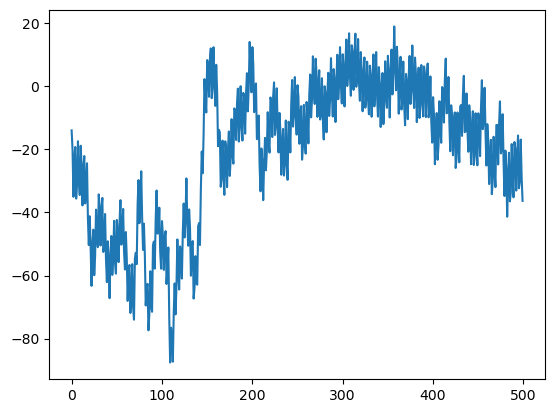

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_X[9, 6, 0])
plt.show()

In [11]:
train_X.shape

(2269, 49, 19, 200)

In [8]:
def norm_feat(train_X, test_X):
    for i in range(train_X.shape[1]):
        min_ = (train_X[:, i, :]).min()
        max_ = (train_X[:, i, :]).max()
        train_X[:, i, :] = (train_X[:, i, :] - min_)/(max_ - min_)
        test_X[:, i, :] = (test_X[:, i, :] - min_)/(max_ - min_)

    return train_X, test_X

In [9]:
generalized_seizure = ["GNSZ", "ABSZ", "TNSZ", "TCSZ", "MYSZ"]
focal_seizure = ["FNSZ", "SPSZ", "CPSZ"]

array([[-44.9  , -50.6  , -61.03 , ..., -79.94 , -60.97 , -67.2  ],
       [-62.6  , -47.03 , -52.62 , ..., -46.4  , -40.25 , -56.75 ],
       [-59.62 , -48.66 , -62.1  , ..., -33.88 , -25.55 , -39.3  ],
       ...,
       [ 12.75 ,   9.21 ,  23.45 , ...,   5.48 ,   6.305,  15.01 ],
       [ -1.213,  -6.81 ,   3.871, ...,  25.61 ,  29.92 ,  40.1  ],
       [ 27.78 ,  23.86 ,  39.4  , ..., -19.78 , -12.18 ,  -1.888]],
      dtype=float16)

In [8]:
"""Coherence connectivity"""

train_X = np.load("../saved_npy_seizure/features/train_X.npy", mmap_mode="c").astype(np.float16)#*1e1
train_y = np.load("../saved_npy_seizure/features/train_y.npy", mmap_mode="c").astype(np.float16)
train_graphs = np.load("../saved_npy_seizure/features/train_graphs_coh.npy", mmap_mode="c").astype(np.float16)
test_y = np.load("../saved_npy_seizure/features/test_y.npy", mmap_mode="c").astype(np.float16)
test_X = np.load("../saved_npy_seizure/features/test_X.npy", mmap_mode="c").astype(np.float16)#*1e1
test_graphs = np.load("../saved_npy_seizure/features/test_graphs_coh.npy", mmap_mode="c").astype(np.float16)
train_X = np.moveaxis(train_X, 1, 2)
test_X = np.moveaxis(test_X, 1, 2)
train_graphs, test_graphs = norm_adj(train_graphs, test_graphs)
#train_X, test_X = norm_feat(train_X, test_X)

bin_test_y = []
for y in test_y:
    if y == [1] or y == [2] or y == [5]:
        bin_test_y.append([0])
    else:
        bin_test_y.append([1])

bin_train_y = []
for y in train_y:
    if y == [1] or y == [2] or y == [5]:
        bin_train_y.append([0])
    else:
        bin_train_y.append([1])

test_y = bin_test_y
train_y = bin_train_y
train_iter, test_iter  = loaders(train_X, train_graphs, train_y, test_X, test_graphs, test_y, DEVICE, BATCH_SIZE, NUM_WINDOWS)

num_epochs = 10
results = []
gt_operators = ["A3TGCN", "GCLSTM", "TGCN", "DCRNN", "GConvGRU"]
for op in gt_operators:
    for i in range(5): #run 5 times
        model = GraphTemporal(num_ch=19, num_t=NUM_WINDOWS, op=op, num_classes=2).to(DEVICE)
        model = train_model(model, num_epochs, train_iter)
        print("Finished "+ op +" Training")
        test_res = print_acc(model, test_iter, binary=True)
        results.append(test_res)

/var/folders/4k/d3wc_jw93m12xqfn1fcfg_2w0000gr/T/ipykernel_13998/1726591026.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  y = torch.tensor([y], dtype=torch.float).to(device)
/var/folders/4k/d3wc_jw93m12xqfn1fcfg_2w0000gr/T/ipykernel_13998/1726591026.py:39: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
/var/folders/4k/d3wc_jw93m12xqfn1fcfg_2w0000gr/T/ipykernel_13998/1726591026.py:40: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  0%|          | 0/10 [00:16<?, ?it/s]


KeyboardInterrupt: 

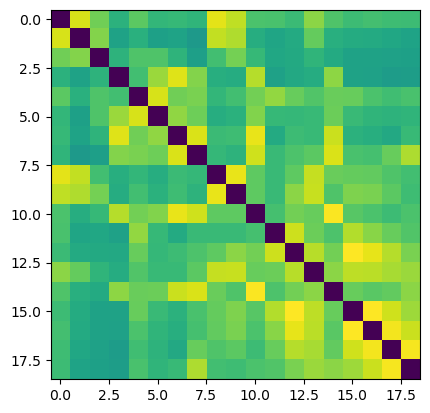

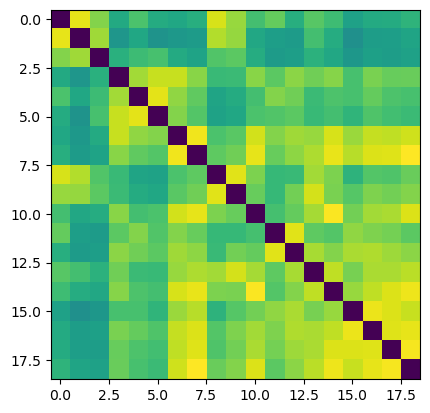

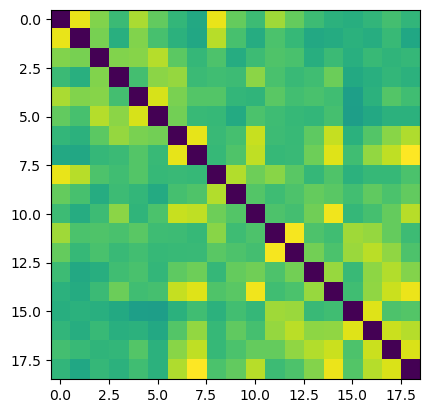

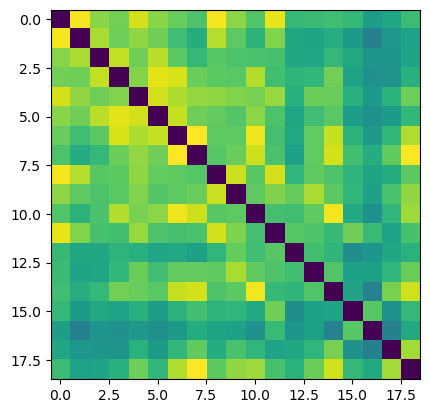

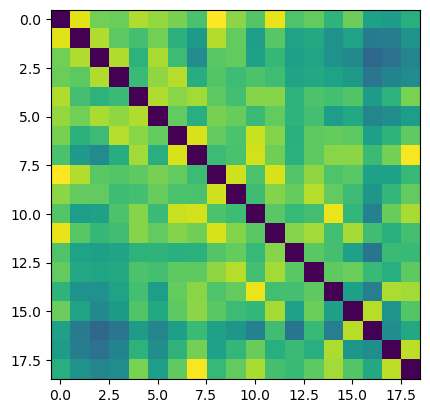

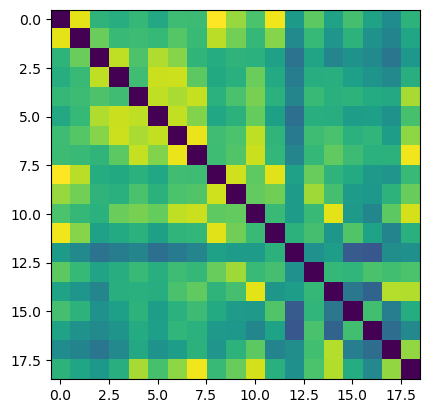

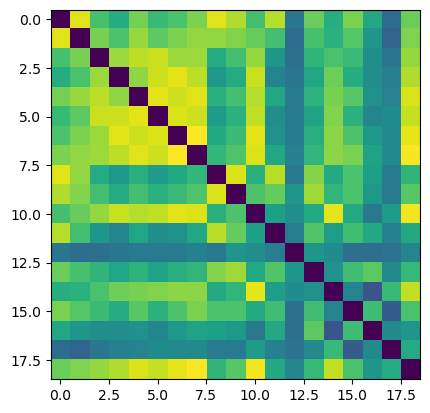

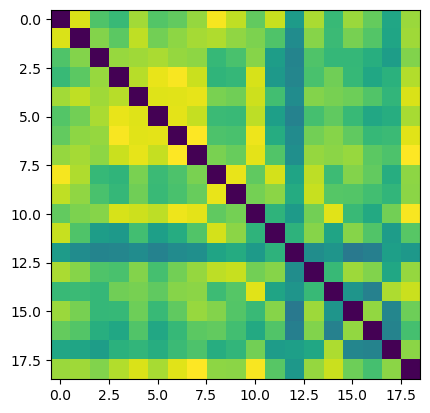

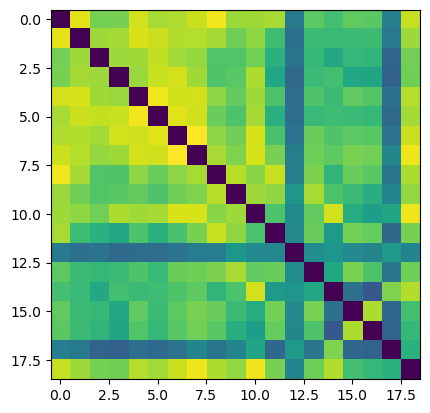

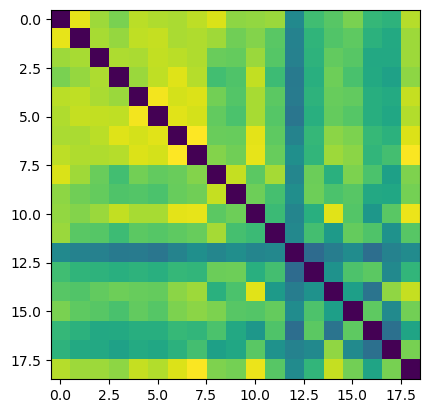

In [25]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.imshow(train_graphs[0, i])
    plt.show()

In [8]:
acc = ["accuracy", "f1", "precision", "recall"]
results = np.array(results).reshape(5, 5, 4)
for idx, res in enumerate(results):
    mean = np.mean(res, axis=0)
    std = np.std(res, axis=0)
    for mi, _ in enumerate(mean):
        print(gt_operators[idx], acc[mi], mean[mi], std[mi])

A3TGCN accuracy 0.8152173913043479 0.01449275362318842
A3TGCN f1 0.7932564665608615 0.00528739111763195
A3TGCN precision 0.7761904761904763 0.05226056391477565
A3TGCN recall 0.8198171635515434 0.06354925334594795
GCLSTM accuracy 0.8188405797101449 0.01760138811810307
GCLSTM f1 0.7874550065726537 0.010497103992489919
GCLSTM precision 0.7333333333333332 0.03570546628318095
GCLSTM recall 0.8565055495882564 0.060348429120432534
TGCN accuracy 0.8115942028985506 0.01875678131238378
TGCN f1 0.7676072507693525 0.04058770125524984
TGCN precision 0.6936507936507936 0.09015537664230429
TGCN recall 0.8747556525847259 0.04460796050402468
DCRNN accuracy 0.8159420289855073 0.026958080054693186
DCRNN f1 0.7802634195488217 0.048192778687440666
DCRNN precision 0.7285714285714285 0.08956657764867228
DCRNN recall 0.8495355965574513 0.022151617838776855
GConvGRU accuracy 0.822463768115942 0.017749925672341866
GConvGRU f1 0.7869744165056437 0.02587379109847582
GConvGRU precision 0.7222222222222222 0.0644764

In [ ]:
"""PLV connectivity"""

train_graphs = np.load("/kaggle/input/tuh-cc/train_graphs_plv.npy", mmap_mode="c").astype(np.float16)
test_graphs = np.load("/kaggle/input/tuh-cc/test_graphs_plv.npy", mmap_mode="c").astype(np.float16)
train_graphs, test_graphs = norm_adj(train_graphs, test_graphs)
train_iter, test_iter  = loaders(train_X, train_graphs, train_y, test_X, test_graphs, test_y, DEVICE, BATCH_SIZE, NUM_WINDOWS)

results = []
gt_operators = ["A3TGCN", "GCLSTM", "TGCN", "DCRNN", "GConvGRU", "GConvLSTM"]
for op in gt_operators:
    for i in range(5):
        model = GraphTemporal(num_ch=19, num_t=200, op=op).to(DEVICE)
        model = train_model(model, num_epochs, train_iter)
        print("Finished "+ op +" Training")
        test_res = print_acc(model, test_iter)
        results.append(test_res)

In [34]:
acc = ["accuracy", "f1", "precision", "recall"]
results = np.array(results).reshape(6, 5, 4)
for idx, res in enumerate(results):
    mean = np.mean(res, axis=0)
    std = np.std(res, axis=0)
    for mi, _ in enumerate(mean):
        print(gt_operators[idx], acc[mi], mean[mi], std[mi])

A3TGCN accuracy 0.822463768115942 0.015709770571506406
A3TGCN f1 0.799878339797796 0.009522857036403935
A3TGCN precision 0.7761904761904761 0.04028119854110956
A3TGCN recall 0.830825492582974 0.05399964391618506
GCLSTM accuracy 0.8130434782608695 0.023547937404741932
GCLSTM f1 0.7968780822129633 0.01753019590502454
GCLSTM precision 0.8031746031746032 0.06816162080502822
GCLSTM recall 0.8006220624255264 0.06056447577762968
TGCN accuracy 0.8065217391304348 0.01460104469536949
TGCN f1 0.7704074189555761 0.0217115812700732
TGCN precision 0.7158730158730159 0.07895130232029138
TGCN recall 0.8483756490848091 0.0635739972561475
DCRNN accuracy 0.8101449275362318 0.009613405189435932
DCRNN f1 0.7789266959065952 0.022316457767338482
DCRNN precision 0.738095238095238 0.06602106140662038
DCRNN recall 0.8345208331600944 0.05158317378578178
GConvGRU accuracy 0.8297101449275364 0.009988441124703054
GConvGRU f1 0.8055052100549641 0.010935622265117236
GConvGRU precision 0.773015873015873 0.034992710611